# DCSI 100 Group Project

## By Alec Jessen, Avery Swoboda, Daniel Wick, Naya Bhatthal 


## Title: An Investigation into the Factors that help Set up a Top Tennis Player for Success

### Introduction:

Tennis is a racquet sport played between one another or teams of 2 opposing each other. It is unclear whether or not certain variables, such as height or age, influence performance and results during a tennis match. In the data set, we are investigating different variables such as height, age, and playing style to determine if there is any correlation (positive or negative) between these factors and the overall performance of the player. Furthermore, we aim to understand if the amount of prize money earned or ranking is supported by the possible correlation between the variables and how these determine a single player’s success.

### Question: “How do variables such as age, backhand playing style (two-handed vs. one-handed) and experience have an effect, if any, on a tennis player’s success level, as measured by current and best rank and prize money earned?”

The dataset analysed to answer the above question will be “Player Stats for Top 500 Players” from ultimate tennis statistics.com. It is a detailed dataset that contains information about the name, age, country of origin, playing style (right-handed or left-handed), backhand (one-handed or two-handed), current and best ranking, current, best and peak elo rating, prize money earned for the top 500 tennis players worldwide, among other variables about their professional life about resources of information acquisition.

In [2]:
#install.packages("rlang")
#install.packages("readr")
#install.packages("dplyr")
#install.packages("ggplot2")
#install.packages("tidyverse")
#install.packages("rvest")
#install.packages("tidymodels")

install.packages("janitor")
install.packages("GGally")
install.packages("ISLR")

library(rlang)
library(dplyr)
library(tidyverse)
library(tidymodels)
library(janitor)
library(rsample)
library(ggplot2)
library(repr)
library(GGally)
library(ISLR)

also installing the dependency ‘snakecase’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Preliminary Data Analysis

In [16]:
# Download the tennis data file from the web into a local .csv file, then tidy the data specific for our analysis

# Make sure this "#" below is removed before submission  !!!!!   (leave for testing for now)
#download.file("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS","player_stats.csv")
tennis_data <- read_csv("player_stats.csv")

tennis_data_tidy <- tennis_data |> 
    select(-Wikipedia) |> 
    clean_names() |>
    select(x1, age, current_rank, best_rank, prize_money, plays, backhand) |>
    na.omit()

# Now Mutate the data to allow for easier analysis
# Inverted the rank
tennis_data_tidy <- tennis_data_tidy |>
  mutate(
    age = as.numeric(sub(" .*", "", age)),
    current_rank = as.numeric(sub(" .*", "", current_rank)),
    best_rank = as.numeric(sub(" .*", "", best_rank)),
    prize_money = str_extract(prize_money, regex("^[^$]*[$]\\s*[0123456789,]+\\b")),
    prize_money = as.numeric(gsub("[^0-9]", "", prize_money)),
    current_rank_rev = 501 - current_rank,
    best_rank_rev = 501 - best_rank
  ) |>
    na.omit()

head(tennis_data_tidy)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


x1,age,current_rank,best_rank,prize_money,plays,backhand,current_rank_rev,best_rank_rev
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,18,326,316,59040,Left-handed,Two-handed,175,185
2,32,178,44,3261567,Right-handed,Two-handed,323,457
3,21,236,130,374093,Right-handed,Two-handed,265,371
4,27,183,17,6091971,Right-handed,Two-handed,318,484
5,22,31,31,1517157,Right-handed,Two-handed,470,470
6,28,307,213,278709,Right-handed,Two-handed,194,288


In [17]:
# !!!!! Double check what the split proportion should be
tennis_split <- initial_split(tennis_data_tidy, prop = 0.8, strata= prize_money) 

training_data <- training(tennis_split)
testing_data <- testing(tennis_split)

#head(training_data)
#nrow(training_data)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Computation failed in `stat_bin()`
Caused by error in `bin_breaks_width()`:
! The number of histogram bins must be less than 1,000,000.
ℹ Did you make `binwidth` too small?”


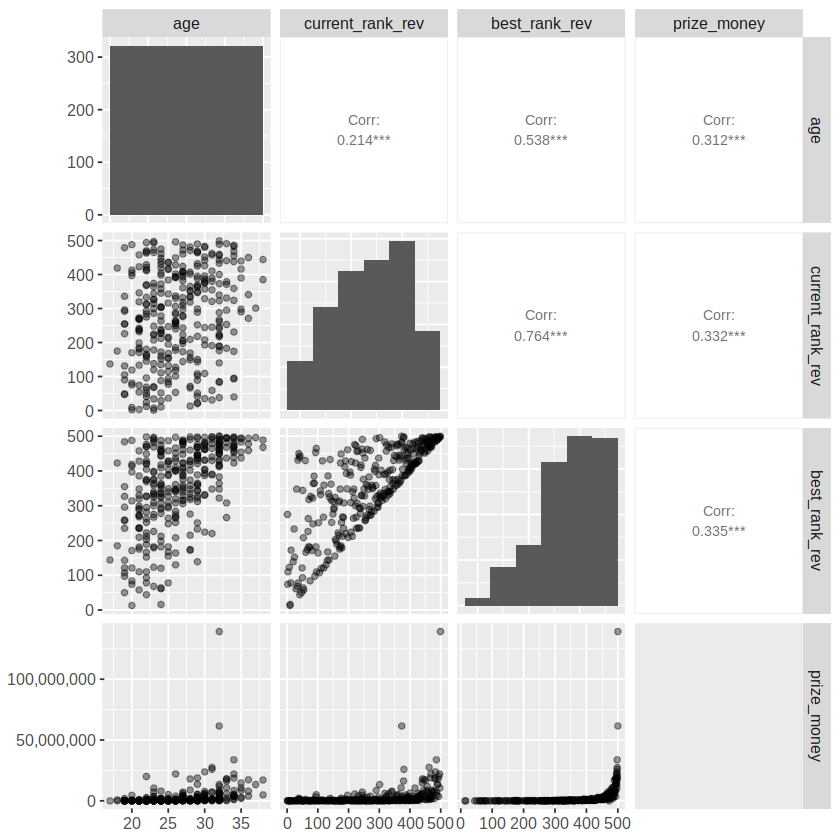

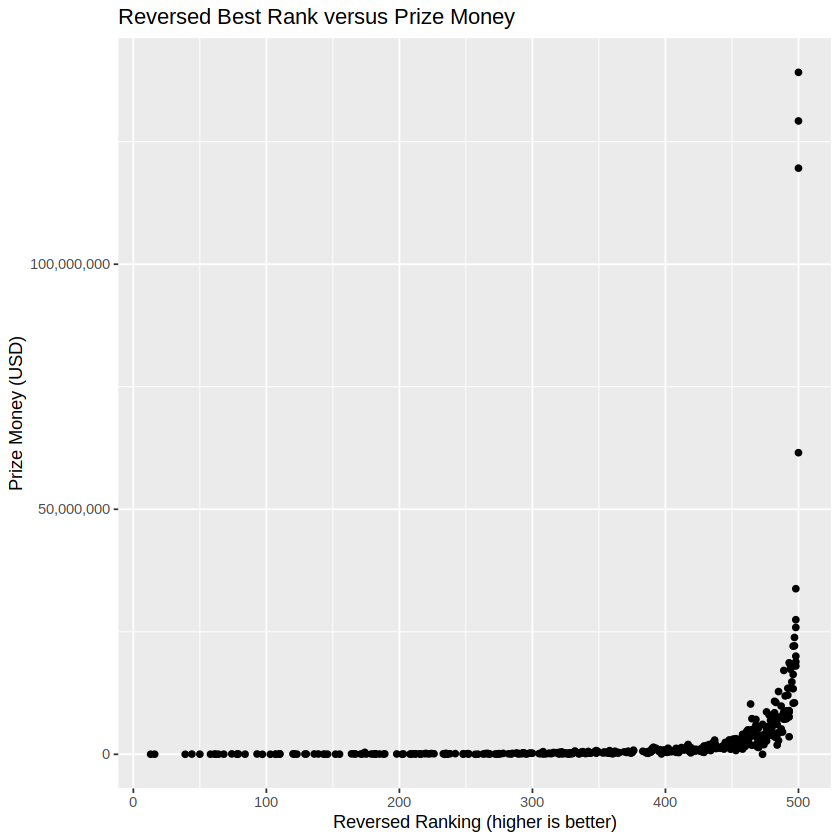

In [20]:
# Pairplot to show basic data comparisons and expected correlation
# !!!!! Update axis, title, etc. to be more readable, and maybe more colorful?
# !!!!! Error with both scale axis and binwidth for prize_money + prize_money plot. Can you set the binwidth for individual plots?

tennis_pairplot <- training_data |> select(age, current_rank_rev, best_rank_rev, prize_money) |>
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = wrap('barDiag', binwidth = 100)), # Adjust binwidth as needed
        upper = list(continuous = wrap('cor', size = 3))) +
    theme(text = element_text(size = 12)) +
    scale_y_continuous(labels = scales::comma) 

tennis_pairplot



# Scatter plot to compare best rank versus prize money, copy later on for regression line addition 

prize_best_rank <- ggplot(tennis_data_tidy, aes(x= best_rank_rev, y= prize_money)) +
    geom_point() +
    labs(x= "Reversed Ranking (higher is better)",
         y= "Prize Money (USD)") +
    scale_y_continuous(labels = scales::comma) +
    ggtitle("Reversed Best Rank versus Prize Money")
    
prize_best_rank


In [24]:
lm_spec <- linear_reg() |>
    set_engine("lm") |> 
    set_mode("regression")

tennis_recipe <- recipe(prize_money ~ age + current_rank_rev + best_rank_rev, 
                        data = training_data)

tennis_fit <- workflow() |>
  add_recipe(tennis_recipe) |>
  add_model(lm_spec) |>
  fit(data = training_data)

tennis_fit

print(lm_spec)
print(tennis_recipe)


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)               age  current_rank_rev     best_rank_rev  
       -16848442            583087             21417             -3742  


Linear Regression Model Specification (regression)

Computational engine: lm 

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3


In [25]:

lm_rmse <- tennis_fit |>
  predict(training_data) |>
  bind_cols(training_data) |>
  metrics(truth = prize_money, estimate = .pred) |>
  filter(.metric == "rmse") |>
  select(.estimate) |>
  pull()

lm_rmse

[1] 8782169

In [ ]:
 tennis_preds <- tennis_fit |>
   predict(training_data) |>
   bind_cols(training_data)

 lm_predictions <- tennis_preds |>
     ggplot(aes(x = age, y = prize_money)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = age, y = .pred), 
             color = "black") +
         xlab("Age (years)") +
         ylab("Prize Money (USD)") +
         theme(text = element_text(size = 20))

lm_predictions

In [ ]:
 
# The problem with this graph is that we are using too many variables and 
# so cannot show the regression line as a comparision between 2 variables 
# because it is not that and so there cannot be a straight line on a graph like this... 
lm_predictions_2 <- tennis_preds |>
     ggplot(aes(x = current_rank, y = prize_money)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = current_rank, y = .pred), 
             color = "black") +
         xlab("Current Rank") +
         ylab("Prize Money (USD)") +
         theme(text = element_text(size=20))

lm_predictions_2

### Methods:

We will use the variables Age, Best Rank, Current Rank, Season, Prize Money and Backhand. Seasons represent the number of seasons played. Backhand refers to either a two-handed or one-handed backhand. For one example, we will create a scatter plot of Seasons Played vs Best Rank with coloured points as Backhand to visualise the correlation. Also, we will use k-nearest neighbours to predict if someone at a given rank and seasons played uses a two-handed or one-handed backhand.

### Expected Outcomes and Significance:

Through this data analysis, we expect to find a correlation between various factors of players and their tennis performance measured via a number of metrics. These findings could help to understand which factors are correlated with better or worse performance in players, perhaps allowing for improvements in the choice of techniques to improve performance or being able to better estimate the performance of newer players. This analysis could lead to further questions about which variables could be changed to improve performance in new athletes, or which metrics of success are most useful for tennis athletes.

